## map2loop: From geology layers to outputs to various 3D modelling programs- Paterson example (Geomodeller)

This notebook reads in three layers from  local or remote sources:  geology polygons, orientation data and fault polylines; and calculates the topological relationships between the different features. Requires compiled cpp code from Vitaliy Ogarko

This all gets fed into successive tolopogical and geometric transfroms that end up feeding into geomodeller to make a 3D model 


In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import sys
import stat
import functools 
import operator  
import matplotlib
import networkx as nx
import rasterio
from shapely.geometry import Polygon
from map2loop import m2l_utils
from map2loop import m2l_topology
from map2loop import m2l_geometry
from map2loop import m2l_interpolation
from map2loop import m2l_export
import time
%matplotlib inline
t0 = time.time()

#newwd="C:\\Users\\00073294\Dropbox\\loop_minex\\map2model\\"
#os.chdir(newwd)
print("Current Working Directory " )

#gdal_data = os.environ['GDAL_DATA']
#print("***",gdal_data)
#print('is dir: ' + str(os.path.isdir(gdal_data)))
#gcs_csv = os.path.join(gdal_data, 'gcs.csv')
#print('is file: ' + str(os.path.isfile(gcs_csv)))
#st = os.stat(gcs_csv)
#print('is readable: ' + str(bool(st.st_mode & stat.S_IRGRP)))
#os.environ['PROJ_LIB']=r"C:\\Users\\00073294\\AppData\\Local\\Continuum\\anaconda3\\Lib\\site-packages\\pyproj\\proj_dir\\share\\proj"
#print(os.getenv('PROJ_LIB'))
print(os.getcwd())

Current Working Directory 
C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\notebooks


## Create bounding box based on inputs

In [2]:
test_data_name='fabiele'

test_data_path='../'+test_data_name+'/'

os.chdir(test_data_path)
%run -i "m2l_config.py"
#%run -i "m2l_config_remote.py"
print(os.getcwd())

bbox2=str(minx)+","+str(miny)+","+str(maxx)+","+str(maxy)
lat_point_list = [miny, miny, maxy, maxy, maxy]
lon_point_list = [minx, maxx, maxx, minx, minx]
bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 
bbox=(minx,miny,maxx,maxy)


Default parameters loaded from ../fabiele/m2l_config.py:
#ROI

step_out=0.1   #padding arounf dtm to ensure reprojected dtm covers target area (in degrees)
inset=0      #unused??

minx=315030  #region of interest coordinates in metre-based system (or non-degree system)
maxx=489111
miny=7512943
maxy=7673071
model_top=5000
model_base=-10000


#PATHS

local_paths=True       #flag to use local or WFS source for data inputs (True = local)

test_data_path='../fabiele/'

geology_file='Geology_FK_V4_FDS.shp'   #input geology file (if local)
fault_file='Structure_FK_V4_FDS.shp' #input fault file (if local)
structure_file='mark_fake_warox.shp' #input bedding orientation file (if local)
mindep_file='mindeps_2018.shp' #input mineral deposit file (if local)

#CRS

src_crs = {'init': 'EPSG:4326'}  # coordinate reference system for imported dtms (geodetic lat/long WGS84)
dst_crs = {'init': 'EPSG:28351'} # coordinate system for data

#CODES AND LABELS 
# these refer to specific fields (codes) in GIS l

In [3]:

fold_decimate=2         

contact_decimate=0

use_interpolations=True       #use interpolated dips/contacts as additional constraints

use_fat=True                   #use fold axial trace orientation hints

pluton_form='saucers'

fault_dip=90

min_fault_length=5000

compute_etc=False

#local_paths=False

#################################
# There are many alternative datasets that can be extracted from the input data, 
# and many choices of possible input data
#
# These flags define what the actual workflow will be for this experiment
#################################
workflow={'seismic_section':False,
          'map':True,
          'cover_map':True,
          'near_fault_interpolations':True,
          'fold_axial_traces':False,
          'stereonets':True,
          'formation_thickness':False,
          'get_remote_dtm':False,
          'fault_offset':False}

dtb_grid=data_path+'young_cover_grid.tif'
dtb_null='-2147483648'

## First we test to see if we have access to the online data we need


In [4]:
loopwfs=m2l_utils.have_access("geo.loop-gis.org")
hawaii=m2l_utils.have_access("pae-paha.pacioos.hawaii.edu")

if(not (loopwfs & hawaii)):
    local_paths=True
    net=False
    print('using local paths')
else:
    net=True

available: geo.loop-gis.org
available: pae-paha.pacioos.hawaii.edu


## Optional WFS source
  
WFS brings in field names as lower case, so need to redefine codes too

In [5]:
if((not local_paths) and net):
    structure_file='http://geo.loop-gis.org/geoserver/loop/wfs?service=WFS&version=1.1.0&request=GetFeature&typeName=warox_points_f5011&bbox='+bbox2+'&srs=EPSG:28350'
    fault_file='http://geo.loop-gis.org/geoserver/loop/wfs?service=WFS&version=1.1.0&request=GetFeature&typeName=linear_500k&bbox='+bbox2+'&srs=EPSG:28350'
    geology_file='http://geo.loop-gis.org/geoserver/loop/wfs?service=WFS&version=1.0.0&request=GetFeature&typeName=loop:geol_500k&bbox='+bbox2+'&srs=EPSG:28350'

    c_l= {
    #Orientations
      "d": "dip",                  #field that contains dip information
      "dd": "dip_dir",             #field that contains dip direction information
      "sf": 'feature',             #field that contains information on type of structure
      "bedding": 'Bed',            #text to search for in field defined by sfcode to show that this is a bedding measurement
    #Stratigraphy
      "g": 'group_',               #field that contains coarser stratigraphic coding
      "c": 'code',                 #field that contains finer stratigraphic coding
      "ds": 'descriptn',           #field that contains information about lithology
      "u": 'unitname',             #field that contains alternate stratigraphic coding (not used??)
      "r1": 'rocktype1',           #field that contains  extra lithology information
      "r2": 'rocktype2',           #field that contains even more lithology information
      "sill": 'sill',              #text to search for in field defined by dscode to show that this is a sill
      "intrusive": 'intrusive',    #text to search for in field defined by dscode to show that this is an intrusion
      "volcanic": 'volcanic',      #text to search for in field defined by dscode to show that this is an intrusion
    #Mineral Deposits
      "msc": 'SITE_CODE',          #field that contains site code of deposit
      "msn": 'SHORT_NAME',         #field that contains short name of deposit
      "mst": 'SITE_TYPE_',         #field that contains site type of deposit
      "mtc": 'TARGET_COM',         #field that contains target commodity of deposit
      "mscm": 'SITE_COMMO',        #field that contains site commodity of deposit
      "mcom": 'COMMODITY_',        #field that contains commodity group of deposit
      "minf": 'Infrastructure',    #text to search for in field defined by mst code that shows site to ignore
    #Timing
      "min": 'min_age_ma',         #field that contains minimum age of unit defined by ccode
      "max": 'max_age_ma',         #field that contains maximum age of unit defined by ccode
    #faults and folds
      "f": 'feature',              #field that contains information on type of structure
      "fault": 'Fault',            #text to search for in field defined by fcode to show that this is a fault
      "fold": 'Fold axial trace',  #text to search for in field defined by fcode to show that this is a fold axial trace
      "n": 'name',                 #field that contains information on name of fault (not used??)
      "t": 'type',                 #field that contains information on type of fold
      "syn": 'syncline',           #text to search for in field defined by t to show that this is a syncline
    #ids
      "o": 'objectid',             #field that contains unique id of geometry object
      "gi": 'geopnt_id'            #field that contains unique id of structure point
    }

## Plot geology polygons and bounding box

../fabiele/data/Geology_FK_V4_FDS.shp


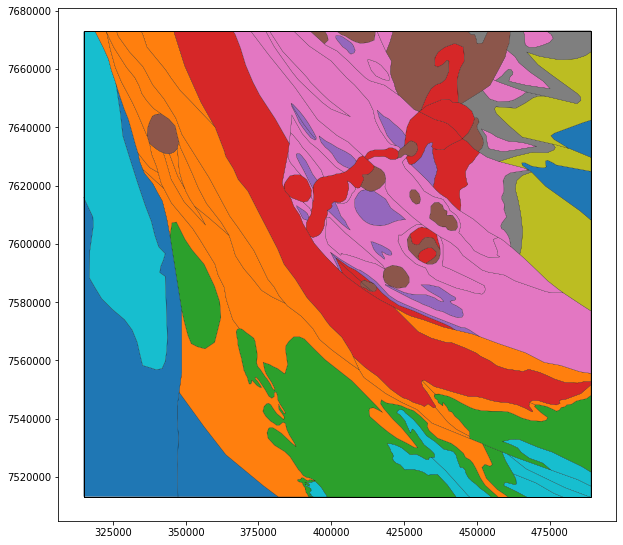

In [6]:
print(geology_file)
geology_ll = gpd.read_file(geology_file,bbox=bbox)

base=geology_ll.plot(column=c_l['c'],figsize=(10,10),edgecolor='#000000',linewidth=0.2)
polygon.plot(ax=base, color='none',edgecolor='black')


## Save geology to file as WKT

In [7]:
hint_flag=False # use GSWA strat database to provide relative age hints
sub_geol = geology_ll[['geometry', c_l['o'],c_l['c'],c_l['g'],c_l['u'],c_l['min'],c_l['max'],c_l['ds'],c_l['r1'],c_l['r2']]]
m2l_topology.save_geol_wkt(sub_geol,geology_file_csv, c_l,hint_flag)

102  polygons


## Save mineral deposits to file as WKT
This is not needed by map2loop to build 3D models, but is used by map2model to calculate mineral deposit/topology analyses.

361  points


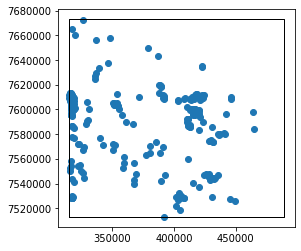

In [8]:
mindep = gpd.read_file(mindep_file,bbox=bbox)

sub_mindep = mindep[['geometry', c_l['msc'],c_l['msn'],c_l['mst'],c_l['mtc'],c_l['mscm'],c_l['mcom']]]
m2l_topology.save_mindep_wkt(sub_mindep,mindep_file_csv, c_l)

base=sub_mindep.plot()
polygon.plot(ax=base, color='none',edgecolor='black')


## Read and save WAROX point data as WKT

169  points


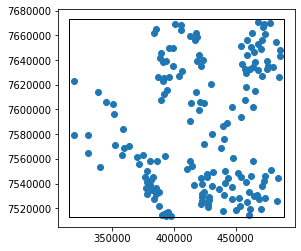

In [9]:
warox = gpd.read_file(structure_file,bbox=bbox)

sub_pts = warox[['geometry', c_l['gi'],c_l['d'],c_l['dd']]]

m2l_topology.save_structure_wkt(sub_pts,structure_file_csv,c_l)

base=sub_pts.plot()
polygon.plot(ax=base, color='none',edgecolor='black')


## Plot faults and bounding box

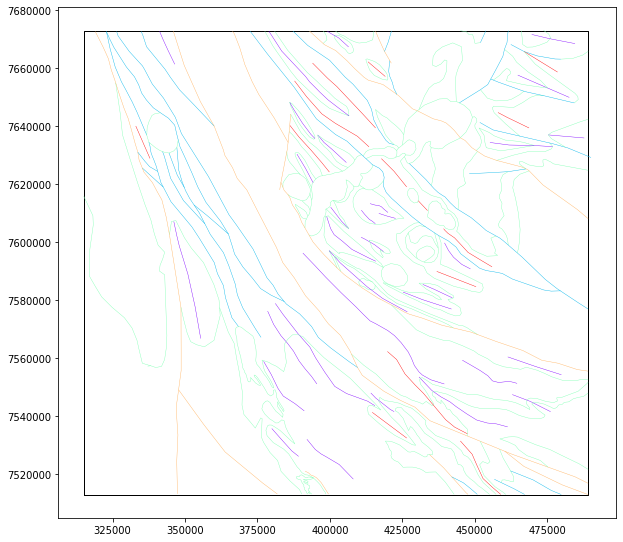

In [10]:
lines_ll=gpd.read_file(fault_file,bbox=bbox)

base2=lines_ll.plot(cmap='rainbow',column=c_l['f'],figsize=(10,10),linewidth=0.4)
polygon.plot(ax=base2, color='none',edgecolor='black')


## Save faults to file as WKT

In [11]:
sub_lines = lines_ll[['geometry', c_l['o'],c_l['f']]]
m2l_topology.save_faults_wkt(sub_lines,fault_file_csv,c_l)

152  polylines


## Create map2model input file

In [12]:
m2l_topology.save_Parfile(m2m_cpp_path,c_l,graph_path,geology_file_csv,fault_file_csv,structure_file_csv,mindep_file_csv,minx,maxx,miny,maxy,500.0,'Fe,Cu,Au,NONE')


## Calculate topology

In [13]:
import subprocess
import platform
os.chdir(m2m_cpp_path)
print(os.getcwd())
#%system map2model.exe Parfile
if(platform.system()=='Windows'):
    subprocess.run(["map2model.exe", "Parfile"], capture_output=True)
else:
    subprocess.run(["./map2model", "Parfile"], capture_output=True)

C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\m2m_cpp


## Simple network graph of the geology with legend

C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


0    'PR'
1    'NYC'
2    'NOT'
3    'NYB'
4    'NYMM'
5    'NYOCg'
6    'NYI'
7    'NYMCg'
8    'NYW'
9    'NYP'
10    'NYZ'
11    'NYY'
12    'NYA'
13    'PC'


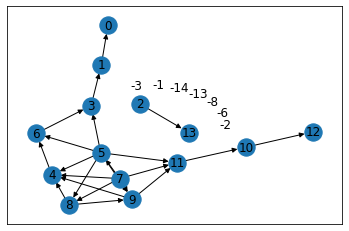

In [14]:
G=nx.read_gml(strat_graph_file,label='id')
selected_nodes = [n for n,v in G.nodes(data=True) if n >=0]
nx.draw_networkx(G, pos=nx.kamada_kawai_layout(G), arrows=True, nodelist=selected_nodes)

nlist=list(G.nodes.data('LabelGraphics'))
nlist.sort()
for no in nlist:
    if(no[0]>=0):
        elem=str(no[1]).replace("{'text':","").replace(", 'fontSize': 14}","")
        #second=elem.split(":").replace("'","")
        print(no[0]," ",elem)

## Detailed Topology via dot or gml format files
For a more detailed look we can open up the online version of <b>yEd</b> <a href="https://www.yworks.com/yed-live/" >https://www.yworks.com/yed-live/</a>  and load in the *.dot file that we will now create or dowload the <a href="https://www.yworks.com/products/yed/download">yEd program</a> and look at the *.gml files in the <b>output</b> directory

from networkx.drawing.nx_pydot import write_dot

import filer,gfiler

filepath=filer.gui_fname().decode('UTF-8')
write_dot(G,filepath)

http://localhost:8888/notebooks/Dropbox/1_Jupyter_notebooks/map2loop/notebooks/2.%20map2loop_after_topology.ipynb

## Process topography, stratigraphy, fold axial traces and faults

### Takes GML file produced by topology code, combines with geology polygons, structure points and dtm to create 3D model in gempy.<br><br>

Limitations:  no dykes, no sills. Sills require us to assign a unique surface to each instance of a sill (sill between units A and B needs to be different from sill of same age and strat codes as one found between E and F). Dykes via cokriging are really hard without just cookie cutting them in (but that is not our problem!). We are not checking for onlap relationships, which can perhaps been seen by having lots of units from one series adjacent to the youngest surface of the older series. Could also think about interpreting these as faults to introduce conceptual uncertainty. All mistakes belong to Mark Jessell, topology code that feeds this system by Vitaliy Ogarko.<br><br>

Geology layer needs to have some unique strat code or text, some group code or text to function<br>
Structure layer needs dip/dip direction<br>

<font color='red'>Currently mostly hardwired to GSWA 500K map so needs work...</font>


In [15]:
os.chdir('../map2loop')

print(os.getcwd())

C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\map2loop


In [16]:
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:80% !important; }</style>"))

sys.path.insert(0,"../..")
print(os.getcwd())


#print(os.getcwd())
#os.environ["PROJ_LIB"] = r"C:\Users\00073294\AppData\Local\Continuum\anaconda3\Lib\site-packages\pyproj\proj_dir\share\proj"


C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\map2loop


## Next we define an area of interest and some other basic stuff

In [17]:
print(os.getcwd())
#test_data_path='../test_data3/'


#%run -i "../test_data3/m2l_config.py"

bbox2=str(minx)+","+str(miny)+","+str(maxx)+","+str(maxy)
lat_point_list = [miny, miny, maxy, maxy, maxy]
lon_point_list = [minx, maxx, maxx, minx, minx]
bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 
bbox=(minx,miny,maxx,maxy)

step_out=0.045 #add (in degrees) so edge pixel from dtm reprojection are not found


#contact_decimate=5

C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\map2loop


## Download and reproject the appropriate SRTM data
mj: Getting this from GA, but could also get from Hawaii

In [18]:
#uncomment next line first time you want to get new dtm
#local_paths=False

polygon_ll=polygon.to_crs(src_crs)

minlong=polygon_ll.total_bounds[0]-step_out
maxlong=polygon_ll.total_bounds[2]+step_out
minlat=polygon_ll.total_bounds[1]-step_out
maxlat=polygon_ll.total_bounds[3]+step_out

print(minlong,maxlong,minlat,maxlat)
if((not local_paths) and net):     
    m2l_utils.get_dtm(dtm_file, minlong,maxlong,minlat,maxlat)
    geom_rp=m2l_utils.reproject_dtm(dtm_file,dtm_reproj_file,src_crs,dst_crs)

if(workflow['cover_map']):
    dtb = rasterio.open(dtb_grid)
    


121.15711456161634 122.9401962393182 -22.534895522763225 -20.988882680428937


## Load stratigraphy graph and create list of series (aka groups)
mj: The choice of what constitutes basic unit and what a group of units is hard-wired at the moment, but could be altered to any pair. Not even sure we need two levels but it seemed like a good idea at the time. Note that this needs the arcgis plugin version of the topology code (for now) as it seperates the different sub graphs. Text outputs list alternate topologies for series and surfaces, which if confirmed by comapring max-min ages will be a nice source of uncertainty.

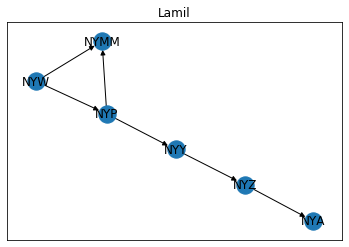

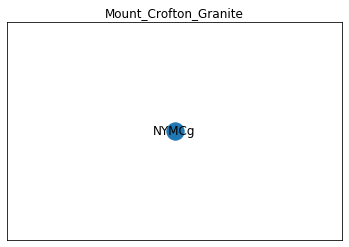

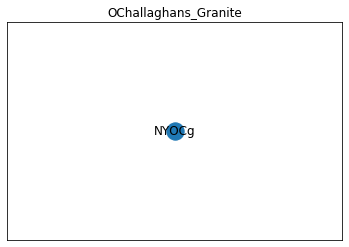

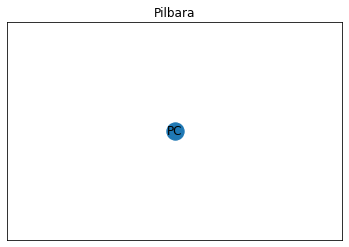

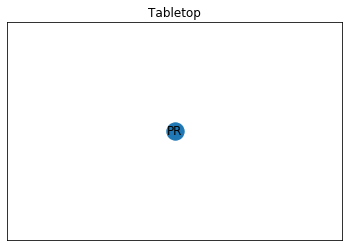

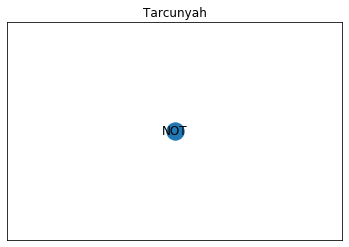

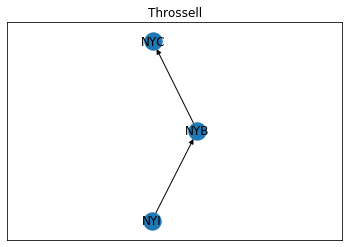

In [19]:
groups,glabels,G = m2l_topology.get_series(strat_graph_file,'id')
m2l_topology.save_units(G,tmp_path,glabels)

## Load geology & structure data
Currently loading from local files, but could load geology from WFS server at GSWA EXCEPT that the WFS online map has less fields that the zipped shapefiles. Go figure. We don't use fault layer at the moment (except for Vitaliy's topology code) but same logic applies in terms of where to get it from. Already have fault/strat relationships and once we have fault/fault relationships will start to include faults in models.

../fabiele/data/Structure_FK_V4_FDS.shp


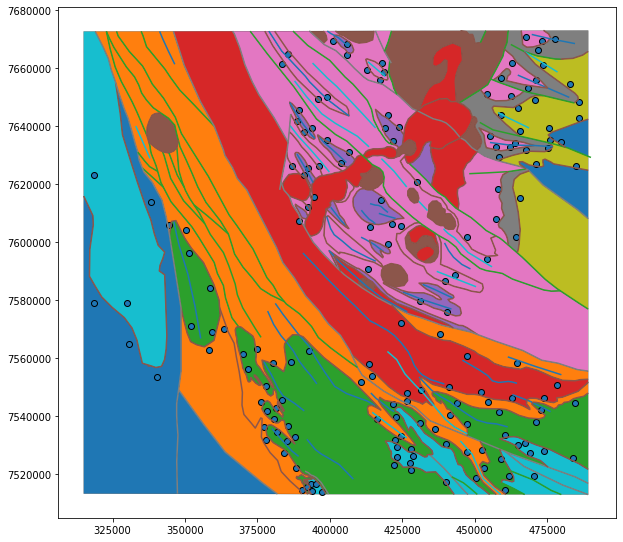

In [20]:
# Extract point data from structure & geology layers for modelling
##First we readin the structure and map from shapefiles, or wherever...

bbox=(minx,miny,maxx,maxy)
geology = gpd.read_file(geology_file,bbox=bbox)


structure = gpd.read_file(structure_file,bbox=bbox)
structure.crs=dst_crs
print(fault_file)
faults = gpd.read_file(fault_file,bbox=bbox)
faults.crs=dst_crs
#display(faults)
sub_pts = structure[['geometry',c_l['d'],c_l['dd'],c_l['sf']]] 

base=geology.plot(column=c_l['c'],figsize=(10,10),edgecolor='#000000',linewidth=0.2)
sub_pts.plot(ax=base,edgecolor='black')
faults.plot(ax=base, column=c_l['f'],edgecolor='black')

## Clip geology, faults, structures and map geology to structures

,geometry,Dip,Dip_Dir,Feature,index_right,OBJECTID,Mag_I_F_T,Rad_I_F_T,Descriptio,Terrane,Zone,Formation,GSWA_Code,Interp_fro,Code,Group_,Rock_type,Lithology_,Age_From,Age_To,GSWA_Map_1
0,POINT (393748.0852882877 7514036.074544451),45.0,240.0,Bedding,0,264,None,None,None,Rudall Complex,Tabletop,Rudall,None,None,PR,Tabletop,Paleoproterozoic Basement,Igneous and metasedimentary rocks,1804,1300,None
1,POINT (393483.5014257866 7516483.475272587),45.0,245.0,Bedding,0,264,None,None,None,Rudall Complex,Tabletop,Rudall,None,None,PR,Tabletop,Paleoproterozoic Basement,Igneous and metasedimentary rocks,1804,1300,None
2,POINT (397319.9674320521 7513969.928578827),45.0,60.0,Bedding,0,264,None,None,None,Rudall Complex,Tabletop,Rudall,None,None,PR,Tabletop,Paleoproterozoic Basement,Igneous and metasedimentary rocks,1804,1300,None
3,POINT (395269.4424976688 7516615.767203837),45.0,40.0,Bedding,0,264,None,None,None,Rudall Complex,Tabletop,Rudall,None,None,PR,Tabletop,Paleoproterozoic Basement,Igneous and metasedimentary rocks,1804,1300,None
4,POINT (392028.2901820307 7515623.577719457),45.0,245.0,Bedding,14,80,None,None,None,Yeneena Basin,Throssell Range,Coolbro Sandstone,None,EM_Mag,NYC,Throssell,Sedimentary rocks,Fluviatile sandstone with minor shale; basal c...,950,910,IBD: Coolbro; Map: Coolbro
5,POINT (390506.9329726495 7514499.096303828),45.0,250.0,Bedding,43,197,None,None,None,Yeneena Basin,Throssell Range,Broadhurst,None,None,NYB,Throssell,Sedimentary rocks,"Interbedded sandstone, siltstone and black sha...",910,870,IBD: Broadhurst; Map: Broadhurst
6,POINT (388191.8241757652 7522039.736385109),45.0,220.0,Bedding,43,197,None,None,None,Yeneena Basin,Throssell Range,Broadhurst,None,None,NYB,Throssell,Sedimentary rocks,"Interbedded sandstone, siltstone and black sha...",910,870,IBD: Broadhurst; Map: Broadhurst
7,POINT (384223.0662382491 7527331.41363513),45.0,220.0,Bedding,43,197,None,None,None,Yeneena Basin,Throssell Range,Broadhurst,None,None,NYB,Throssell,Sedimentary rocks,"Interbedded sandstone, siltstone and black sha...",910,870,IBD: Broadhurst; Map: Broadhurst
8,POINT (377873.0535382234 7531829.339297649),45.0,225.0,Bedding,43,197,None,None,None,Yeneena Basin,Throssell Range,Broadhurst,None,None,NYB,Throssell,Sedimentary rocks,"Interbedded sandstone, siltstone and black sha...",910,870,IBD: Broadhurst; Map: Broadhurst
9,POINT (381841.8114757395 7534607.46985391),45.0,35.0,Bedding,14,80,None,None,None,Yeneena Basin,Throssell Range,Coolbro Sandstone,None,EM_Mag,NYC,Throssell,Sedimentary rocks,Fluviatile sandstone with minor shale; basal c...,950,910,IBD: Coolbro; Map: Coolbro


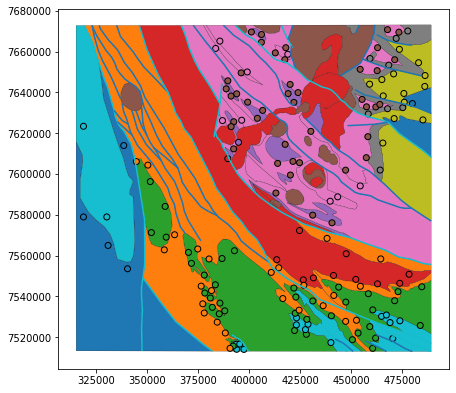

In [21]:
geology = m2l_utils.explode(geology)
geology.crs = dst_crs
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)
structure_code = gpd.sjoin(sub_pts, geology, how="left", op="within")

y_point_list = [miny, miny, maxy, maxy, miny]
x_point_list = [minx, maxx, maxx, minx, minx]

bbox_geom = Polygon(zip(x_point_list, y_point_list))

polygo = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 
#display(polygo.geometry)
is_bed=structure_code[c_l['sf']].str.contains(c_l['bedding'], regex=False) 
    
all_beds = structure_code[is_bed]
#display(sfcode)
all_folds=faults[faults[c_l['f']].str.contains(c_l['fold'])]
if(len(all_folds)>0):
    folds_clip=m2l_utils.clip_shp(all_folds,polygo)
    folds_clip.to_file(tmp_path+'folds_clip.shp')


all_faults=faults[faults[c_l['f']].str.contains(c_l['fault'])]



#display(structure_code)
#geol_clip=m2l_utils.clip_shp(geology, polygo)
geol_clip=gpd.overlay(geology, polygo, how='intersection')
faults_clip=m2l_utils.clip_shp(all_faults,polygo)
#display(faults_clip)
structure_clip = m2l_utils.clip_shp(all_beds, polygo)

base = geol_clip.plot(column=c_l['c'],figsize=(7,7),edgecolor='#000000',linewidth=0.2)
faults_clip.plot(ax=base, column=c_l['t'],edgecolor='black')
structure_clip.plot(ax=base, column=c_l['c'],edgecolor='black')
#structure_clip.plot(ax=base, edgecolor='black')


if(c_l['dd']=='strike'):
    structure_clip['azimuth2'] = structure_clip.apply(lambda row: row[c_l['dd']]+90.0, axis = 1)
    c_l['dd']='azimuth2'
    
    
geol_clip.to_file(tmp_path+'geol_clip.shp')
faults_clip.to_file(tmp_path+'faults_clip.shp')
structure_clip.to_file(tmp_path+'structure_clip.shp')
display(structure_clip)

## Create possible stratigraphy sets per group
mj: <font color='red'>Uses first of each possible set of toplogies per unit and per group, which is arbitrary. </font>On the other hand we are not checking relative ages again to see if this helps reduce ambiguity, which I think it would.

,index,min,max,ave
group_,,,,
OChallaghans_Granite,0,640.0,650.0,645.0
Mount_Crofton_Granite,1,640.0,650.0,645.0
Lamil,2,649.0,831.0,740.0
Throssell,3,830.0,950.0,890.0
Tarcunyah,4,1000.0,1200.0,1100.0
Tabletop,5,1300.0,1804.0,1552.0
Pilbara,6,2700.0,3000.0,2850.0


[]

group choices: 42


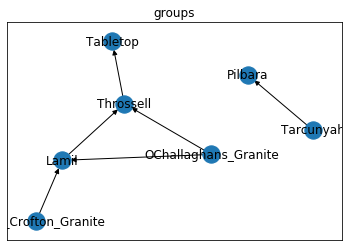

In [22]:
m2l_topology.save_group(G,tmp_path,glabels,geol_clip,c_l)

## Export orientation data in csv  format
mj: Orientation data needs calculated height as file does not provide it, taken from SRTM data already downloaded. To calculate polarity <font color='red'>(WHICH WE DON'T DO YET, but test code available)</font> we can calculate the dot product of the dip direction of a bedding plane and the vector to that points nearest basal contact node, if  abs(acos(dot product))>90  then right way up :

<img src='../graphics/polarity.png'>

Added code to not save intrusion orientation data as they won't have associated surfaces if sill...

## Calculate cover depth grid and contacts    
Grid is assumed to be of depth below surface   

Also need to cater for case when we only have grid, no shapefile, so need to add a fake horizontal orientation in the middle of the map at average depth.

In [23]:
from shapely.geometry import shape, Polygon, LineString, Point, MultiLineString
from math import acos, sqrt, cos, sin, degrees, radians, fabs, atan2
import rasterio
import rasterio.mask as mask
import fiona

dtb_grid=data_path+'young_cover_grid.tif'
dtb_null='-2147483648'

dtm = rasterio.open(dtm_reproj_file)
dtb_raw = rasterio.open(dtb_grid)

spacing=5000
cover_map_path=data_path+'Young_Cover_FDS_MGA_clean.shp'
cover=gpd.read_file(cover_map_path)
cover_dip=10
dtb_clip=output_path+'young_cover_grid_clip.tif'


with fiona.open(cover_map_path, "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

with rasterio.open(dtb_grid) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta.copy()
    
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open(dtb_clip, "w", **out_meta) as dest:
    dest.write(out_image)  
    
dtb = rasterio.open(dtb_clip)
 

In [24]:
   
m2l_geometry.process_cover(output_path,dtm,dtb,dtb_null,cover,workflow['cover_map'],cover_dip,bbox,dst_crs,spacing,contact_decimate=3,use_vector=True,use_grid=True)    

C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\tools\sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


cover grid saved out as ../fabiele/output/cover_grid.csv


In [25]:
dtm = rasterio.open(dtm_reproj_file)

m2l_geometry.save_orientations(structure_clip,output_path,c_l,orientation_decimate,dtm,dtb,dtb_null,workflow['cover_map'])
c_l['r1']='Rock_type'


168 orientations saved to ../fabiele/output/orientations.csv


## Display stereonets of bedding by formations and group to see how we can combine them later

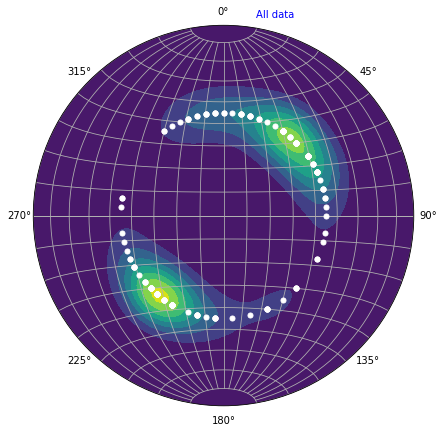

----------------------------------------------------------------------------------------------------------------------
Lamil observations n= 74


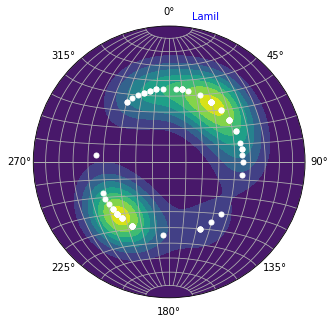

----------------------------------------------------------------------------------------------------------------------
Throssell observations n= 74


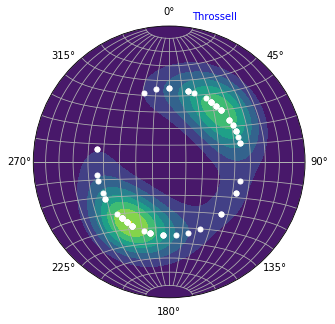

----------------------------------------------------------------------------------------------------------------------
Tabletop observations n= 14


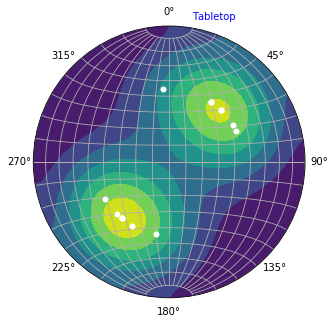

----------------------------------------------------------------------------------------------------------------------
Tarcunyah observations n= 4


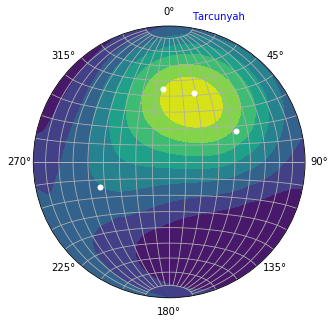

----------------------------------------------------------------------------------------------------------------------
Pilbara observations n= 2


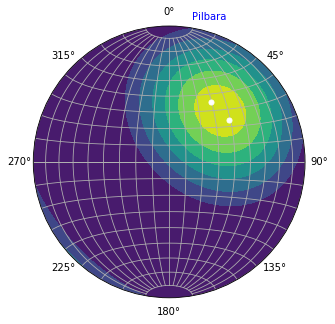

----------------------------------------------------------------------------------------------------------------------
OChallaghans_Granite
NYOCg observations n= 0
----------------------------------------------------------------------------------------------------------------------
Mount_Crofton_Granite
NYMCg observations n= 0
----------------------------------------------------------------------------------------------------------------------
Lamil
NYW observations n= 9
NYP observations n= 35
NYY observations n= 8


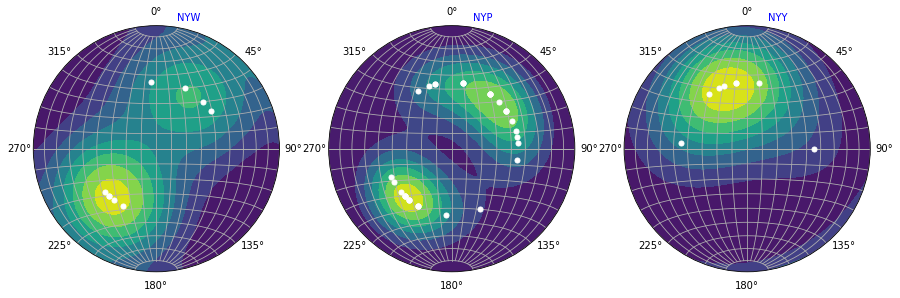

NYZ observations n= 13
NYA observations n= 1
NYMM observations n= 8


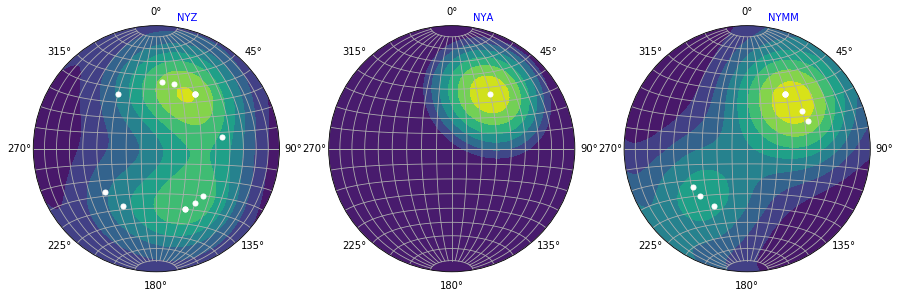

----------------------------------------------------------------------------------------------------------------------
Throssell
NYI observations n= 11
NYB observations n= 25
NYC observations n= 38


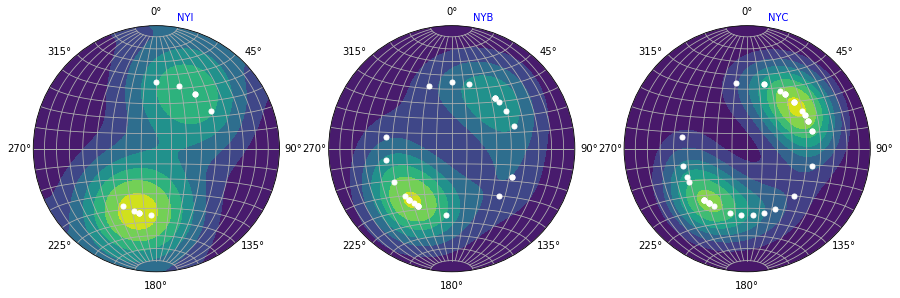

----------------------------------------------------------------------------------------------------------------------
Tabletop
PR observations n= 14


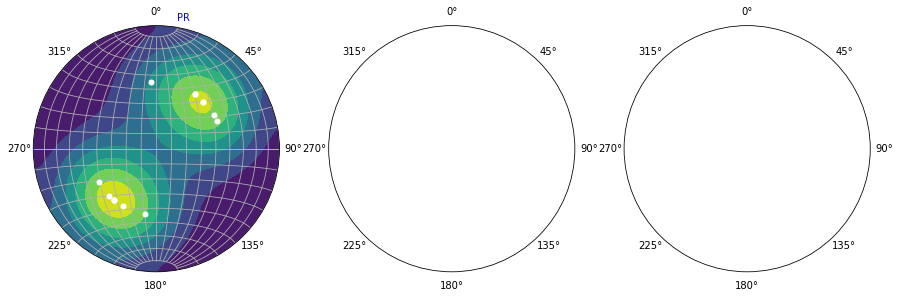

----------------------------------------------------------------------------------------------------------------------
Tarcunyah
NOT observations n= 4


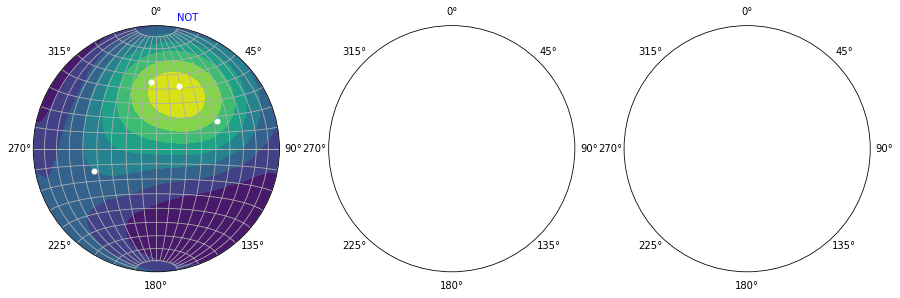

----------------------------------------------------------------------------------------------------------------------
Pilbara
PC observations n= 2


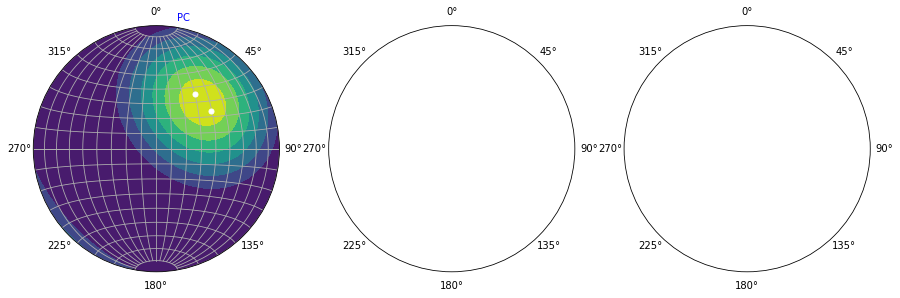

In [26]:
orientations=pd.read_csv(output_path+'orientations.csv',",")
all_sorts=pd.read_csv(tmp_path+'all_sorts.csv',",")
            
m2l_utils.plot_bedding_stereonets(orientations,all_sorts)

## Find those series that don't have any orientation or contact point data  then create arbitrary point for series with no orientation data
Not sure if gempy needs this but geomodeller does. Currently just gives a point dipping 45 degrees to North, but could use dip direction normal to basal surface)

In [27]:
m2l_geometry.create_orientations( tmp_path, output_path, dtm,dtb,dtb_null,workflow['cover_map'],geol_clip,structure_clip,c_l)

extra orientations saved as ../fabiele/output//empty_series_orientations.csv


## Export contact information subset of each polygon to gempy format
mj: Orientation data needs calculated height as file does not provide it, taken from SRTM data already downloaded. Need to reduce number of points whilst retaining useful info (Ranee's job!)'
To calculate which are the basal units contact for a polygon find the polygons which are older than the selected polygon, in the example below the central polygon has relative age 23 so its basal contact is with the polygons whose ages are 26 & 28. If there are no older units for a polygon it has no basal content. We keep every nth node based on the decimate term (simple count along polyline). gempy seems to need at least two points per surface, so we always take the first two points.


<img src='../graphics/base.png'>

In [28]:
ls_dict,ls_dict_decimate=m2l_geometry.save_basal_contacts(tmp_path,dtm,dtb,dtb_null,workflow['cover_map'],geol_clip,contact_decimate,c_l,intrusion_mode)

basal contacts saved allpts= 1243 deci_pts= 1243
saved as ../fabiele/tmp/all_contacts.csv and ../fabiele/tmp/contacts.csv


## Remove all basal contacts that are defined by faults and save to shapefile (no decimation)

In [29]:
display(ls_dict)

{0: {'id': 0,
  'Code': 'NYC',
  'Group_': 'Throssell',
  'geometry': <shapely.geometry.multilinestring.MultiLineString at 0x11f313b3ac8>},
 1: {'id': 1,
  'Code': 'NYC',
  'Group_': 'Throssell',
  'geometry': <shapely.geometry.multilinestring.MultiLineString at 0x11f313b3e80>},
 2: {'id': 2,
  'Code': 'NYC',
  'Group_': 'Throssell',
  'geometry': <shapely.geometry.multilinestring.MultiLineString at 0x11f31d3c080>},
 3: {'id': 3,
  'Code': 'NYC',
  'Group_': 'Throssell',
  'geometry': <shapely.geometry.multilinestring.MultiLineString at 0x11f312cab00>},
 4: {'id': 4,
  'Code': 'NYB',
  'Group_': 'Throssell',
  'geometry': <shapely.geometry.multilinestring.MultiLineString at 0x11f3166dc50>},
 5: {'id': 5,
  'Code': 'NYB',
  'Group_': 'Throssell',
  'geometry': <shapely.geometry.multilinestring.MultiLineString at 0x11f312caba8>},
 6: {'id': 6,
  'Code': 'NYB',
  'Group_': 'Throssell',
  'geometry': <shapely.geometry.multilinestring.MultiLineString at 0x11f3125f978>},
 7: {'id': 7,
  'Cod

In [30]:
m2l_geometry.save_basal_no_faults(tmp_path+'basal_contacts.shp',tmp_path+'faults_clip.shp',ls_dict,10,c_l,dst_crs)

basal contacts without faults saved as ../fabiele/tmp/basal_contacts.shp


## Remove faults from decimated basal contacts as save as csv file

In [31]:
contacts=gpd.read_file(tmp_path+'basal_contacts.shp')

m2l_geometry.save_basal_contacts_csv(contacts,output_path,dtm,dtb,dtb_null,workflow['cover_map'],contact_decimate,c_l)

#m2l_geometry.save_contacts_with_faults_removed(tmp_path+'faults_clip.shp',output_path,10,ls_dict,ls_dict_decimate,c_l,dst_crs,dtm)

decimated contacts saved as ../fabiele/output/contacts4.csv


## Propagate dips along contacts


In [32]:
contact_dip=45
m2l_geometry.save_basal_contacts_orientations_csv(contacts,orientations,geol_clip,tmp_path,output_path,dtm,dtb,
                                         dtb_null,workflow['cover_map'],0,c_l,contact_dip)

## Process fault geometry
Save Faults as decimated points and representative orientation  
Then, for each  fault string:
- incementally advance along polyline every at each inter-node (no point in doing more?)
- find local stratigraphy 10m to left and right of fault
  
Once full fault has been traversed:
- Find list of contacts left 
- Find equivalent contacts on right
- use interpolated orientations to estimate minimum true offset assuming vertical displacement and store 
- if no equivalent found, flag as domain fault and find min strat offset for contact, use cumulative minimum thickness estimate and store with flag (not implemented)
- estimate median & sd of minimum fault offset and store with flag (not implemented)

Local Orientations
Since much of the code is the same, we benefit by calculating local orientation data either side of fault so that geomodeller/gempy have satisfied fault compartment orientation data## Save fault as contact info and and orientation info make vertical (for the moment)

In [33]:
m2l_geometry.save_faults(tmp_path+'faults_clip.shp',output_path,dtm,dtb,dtb_null,workflow['cover_map'],c_l,fault_decimate,min_fault_length,fault_dip)

use_gcode=('Lamil','Throssell') 
use_gcode2=('Lamil','Throssell'  ) 

m2l_interpolation.process_fault_throw_and_near_orientations(tmp_path,output_path,dtm_reproj_file,dtb,dtb_null,workflow['cover_map'],c_l,use_gcode,use_gcode2,dst_crs,bbox,scheme)



fault orientations saved as ../fabiele/output/fault_orientations.csv
fault positions saved as ../fabiele/output/faults.csv
fault dimensions saved as ../fabiele/output/fault_dimensions.csv
orientations interpolated as dip dip direction ../fabiele/tmp/f_interpolation_scipy_rbf.csv
orientations interpolated as l,m,n dir cos ../fabiele/tmp/f_interpolation_l.csv etc.
orientations interpolated as dip dip direction ../fabiele/tmp/ex_f_interpolation_scipy_rbf.csv
orientations interpolated as l,m,n dir cos ../fabiele/tmp/ex_f_interpolation_l.csv etc.


C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\interpolate\rbf.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=1.50251e-28): result may not be accurate.
  self.nodes = linalg.solve(self.A, self.di)


contacts interpolated as strike ../fabiele/tmp/f_interpolation_contacts_scipy_rbf.csv
contacts interpolated as l,m dir cos ../fabiele/tmp/f_interpolation_contacts_l.csv etc.


C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\interpolate\rbf.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=4.24196e-27): result may not be accurate.
  self.nodes = linalg.solve(self.A, self.di)


contacts interpolated as strike ../fabiele/tmp/ex_f_interpolation_contacts_scipy_rbf.csv
contacts interpolated as l,m dir cos ../fabiele/tmp/ex_f_interpolation_contacts_l.csv etc.
{'init': 'EPSG:28351'} None
contacts and orientations interpolated as dip dip direction ../fabiele/tmp/f_combo_full.csv
{'init': 'EPSG:28351'} None
contacts and orientations interpolated as dip dip direction ../fabiele/tmp/ex_f_combo_full.csv


## Process plutons

For each instruve but not sill polygon, find older neighbours and store decimated contact points. Also store dipping contact orientations (user defined, just because) with four possible sub-surface configurations:

<b>saucers: \\_+++_/ <br>
batholiths: +++/__ __ _\\+++  <br> 
domes: /‾+++‾\\ <br>
pendants: +++\\_  _/+++ <br>
</b>
  
Saves out orientations and contact points, as well as updated group level stratigraphic column.<br>


In [34]:
bbox=(minx,miny,maxx,maxy)

pluton_dip=str(pluton_dip)

dist_buffer=10
dtm = rasterio.open(dtm_reproj_file)
m2l_geometry.process_plutons(tmp_path,output_path,geol_clip,local_paths,dtm,dtb,dtb_null,workflow['cover_map'],pluton_form,pluton_dip,contact_decimate,c_l)



0 OChallaghans_Granite
1 Mount_Crofton_Granite
2 Lamil
3 Throssell
4 Tabletop
5 Tarcunyah
6 Pilbara
pluton contacts and orientations saved as:
../fabiele/output/ign_contacts.csv
../fabiele/output/ign_orientations_saucers.csv


## Extract faults and basal contacts of groups from seismic section

In [35]:
if(workflow['seismic_section']):
    seismic_line_file=data_path+'seismic_line_10GA-CP1_rev.shp'   #input geology file (if local)
    seismic_line = gpd.read_file(seismic_line_file) #import map
    seismic_line.plot(figsize=(10,10),edgecolor='#000000',linewidth=0.2) #display map
    display(seismic_line)


    seismic_bbox_file=data_path+'seismic_bbox.shp'   #input geology file (if local)
    seismic_bbox = gpd.read_file(seismic_bbox_file) #import map
    seismic_bbox.set_index('POSITION',inplace=True)

    seismic_interp_file=data_path+'seismic_interp.shp'   #input geology file (if local)
    seismic_interp = gpd.read_file(seismic_interp_file) #import map
    seismic_interp.plot(column='FEATURE',figsize=(10,10),edgecolor='#000000',linewidth=0.5) #display map
    display(seismic_interp)

    dtm_reproj_file=dtm_path+'dtm_rp.tif'
    dtm = rasterio.open(dtm_reproj_file)

    surface_cut=2000

    m2l_geometry.extract_section(tmp_path,output_path,seismic_line,seismic_bbox,seismic_interp,dtm,surface_cut)

    contacts=pd.read_csv(output_path+'contacts4.csv',",")
    seismic_contacts=pd.read_csv(output_path+'seismic_base.csv',",")
    all_contacts=pd.concat([contacts,seismic_contacts],sort=False)
    all_contacts.to_csv (output_path+'contacts4.csv', index = None, header=True)

    faults=pd.read_csv(output_path+'faults.csv',",")
    seismic_faults=pd.read_csv(output_path+'seismic_faults.csv',",")
    all_faults=pd.concat([faults,seismic_faults],sort=False)
    all_faults.to_csv (output_path+'faults.csv', index = None, header=True)

## Interpolates a regular grid of orientations from an  shapefile of arbitrarily-located points and saves out four csv files of l,m & n direction cosines and dip dip direction data

Can choose between various RBF and IDW options   
  
The purpose of these interpolations and associated code is to help in three cases:
- Providing estimated dips and contacts in fault-bounded domains where no structural data are available
- Needed to estimate true thickness of formations
- Possibly useful for poulating parts of maps where little structural data is available

In [36]:
use_gcode=('Lamil','Throssell' ) ################# MOVE UP   #########################
structure_file=tmp_path+'structure_clip.shp'
bbox=(minx+inset,miny+inset,maxx-inset,maxy-inset)

In [37]:
print(c_l['g'])
print(use_gcode)

Group_
('Lamil', 'Throssell')


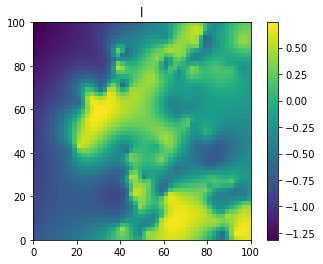

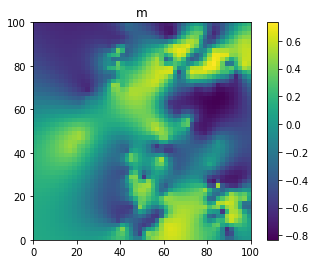

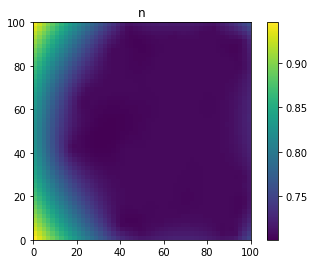

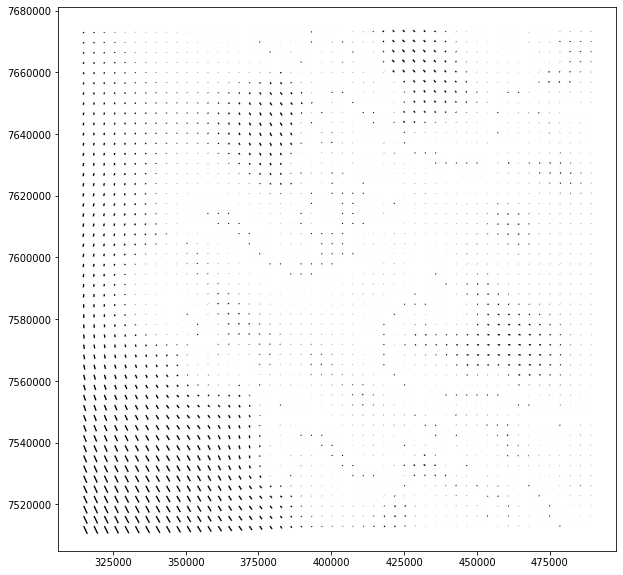

orientations interpolated as dip dip direction ../fabiele/tmp/interpolation_scipy_rbf.csv
orientations interpolated as l,m,n dir cos ../fabiele/tmp/interpolation_l.csv etc.


In [38]:
#scheme='simple_idw'      #interpolation scheme
m2l_interpolation.interpolate_orientations(structure_file,tmp_path,bbox,c_l,use_gcode,scheme,gridx,gridy,False)

## Interpolates a regular grid from a shapefile of from contacts and saves out three csv files of l & m direction cosines and strike data

Can choose between various RBF and IDW options  

<font face color='red'>Best with basal contacts only, using Notebook #1 as this avoids intrusive  and fault contacts being considered</font>

In [39]:
geology_file=tmp_path+'basal_contacts.shp'

dtm = rasterio.open(dtm_reproj_file)
use_gcode=('Lamil','Throssell'  ) ################# MOVE UP   #########################


58
534 points saved to ../fabiele/tmp/raw_contacts.csv


C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\interpolate\rbf.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=2.6811e-27): result may not be accurate.
  self.nodes = linalg.solve(self.A, self.di)


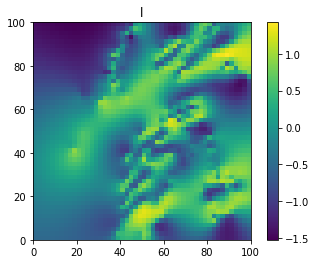

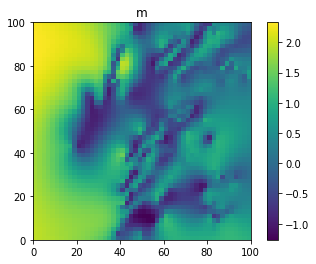

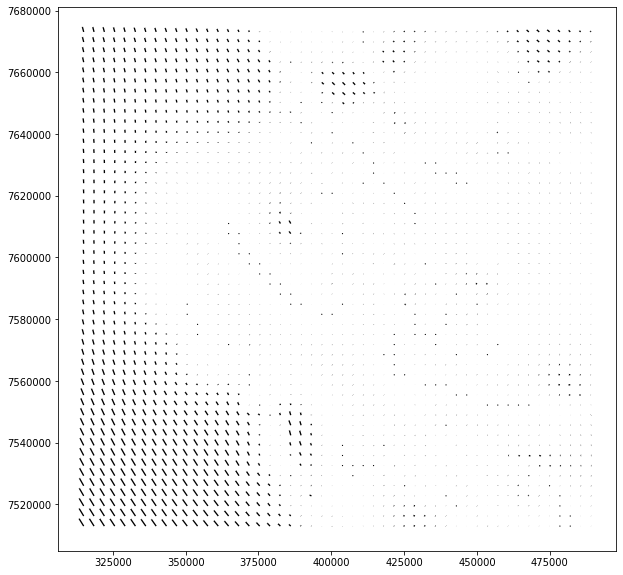

contacts interpolated as strike ../fabiele/tmp/interpolation_contacts_scipy_rbf.csv
contacts interpolated as l,m dir cos ../fabiele/tmp/interpolation_contacts_l.csv etc.


In [40]:
contact_decimate=2
null_scheme='null'

m2l_interpolation.save_contact_vectors(geology_file,tmp_path,dtm,dtb,dtb_null,workflow['cover_map'],bbox,c_l,null_scheme,contact_decimate)

m2l_interpolation.interpolate_contacts(geology_file,tmp_path,dtm,dtb,dtb_null,workflow['cover_map'],bbox,c_l,use_gcode,scheme,gridx,gridy,False)


## Combines rbf of contact orientations with rbf of dip/dipdir measurements

Uses normalised direction cosines **(l,m,n)**:  
- **l,m** from RBF of basal contact orientations  
- **signs of l & m** from misorientation with RBF of orientation data and  
- **n** from RBF of orientation data  
  
May be useful for adding data where no orientations are available (e.g. in fault bounded domains) and for calculating true thickness of layers. Assumes a 2D plane of data, but if 3D RBF was calulated and projected contact info was used it should apply with topography too. 

In [41]:
geology_file=tmp_path+'geol_clip.shp'
combo_file=tmp_path+'combo.csv'

lc=np.loadtxt(tmp_path+'interpolation_contacts_l.csv',skiprows =1,delimiter =',',dtype=float)
mc=np.loadtxt(tmp_path+'interpolation_contacts_m.csv',skiprows =1,delimiter =',',dtype=float)
lo=np.loadtxt(tmp_path+'interpolation_l.csv',skiprows =1,delimiter =',',dtype=float)
mo=np.loadtxt(tmp_path+'interpolation_m.csv',skiprows =1,delimiter =',',dtype=float)
no=np.loadtxt(tmp_path+'interpolation_n.csv',skiprows =1,delimiter =',',dtype=float)
xy=np.loadtxt(tmp_path+'interpolation_'+scheme+'.csv',skiprows =1,delimiter =',',dtype=float)

In [42]:
m2l_interpolation.join_contacts_and_orientations(combo_file,geology_file,tmp_path,dtm_reproj_file,dtb,dtb_null,workflow['cover_map'],c_l,lo,mo,no,lc,mc,xy,dst_crs,bbox,False)


{'init': 'EPSG:28351'} None
contacts and orientations interpolated as dip dip direction ../fabiele/tmp/combo_full.csv


## Estimate formation thickness and normalised formation thickness

In [43]:
buffer =5000
max_thickness_allowed=10000

m2l_geometry.calc_thickness(tmp_path,output_path,buffer,max_thickness_allowed,c_l)

m2l_geometry.normalise_thickness(output_path)

247 thickness estimates saved as ../fabiele/output/formation_thicknesses.csv
NYC 1347.0 715.6783739974335
NYB 1216.0 658.5918588737231
NYP 1436.0 696.9915282806885
NYY 2248.0 553.8433315455156
NYZ 2786.0 747.2908211858162


## Creates fold axial trace points

In [44]:
m2l_geometry.save_fold_axial_traces(tmp_path+'folds_clip.shp',output_path,dtm,dtb,dtb_null,workflow['cover_map'],c_l,fold_decimate)

#Save fold axial trace near-hinge orientations
fat_step=750         # how much to step out normal to fold axial trace
close_dip=20.0       #dip to assign to all new orientations
   
m2l_geometry.save_fold_axial_traces_orientations(tmp_path+'folds_clip.shp',output_path,tmp_path,dtm,dtb,dtb_null,workflow['cover_map'],c_l,dst_crs,fold_decimate,fat_step,close_dip,scheme)

fold axial traces saved as ../fabiele/output/fold_axial_traces.csv
fold axial traces saved as ../fabiele/output/fold_axial_traces.csv
fold axial trace orientations saved as ../fabiele/output/fold_axial_trace_orientations.csv


## Preprocess data to ensure it meets modelling requirements

In [45]:
if(local_paths): ###############FUDGE#############
    use_gcode=('Tarcunyah','Pilbara','OChallaghans_Granite','Mount_Crofton_Granite','Lamil','Throssell' ,'Tabletop' ,'cover' ) ################# MOVE UP   #########################
    use_gcode=('Tarcunyah','Pilbara','OChallaghans_Granite','Mount_Crofton_Granite','Lamil','Throssell' ,'Tabletop' ,'cover' ) ################# MOVE UP   #########################
else:
    use_gcode=('Hamersley_Group','Fortescue_Group','Wyloo_Group','Shingle_Creek_Group','Turee_Creek_Group','A_mgn_PMI',  'A_mgn_PRK' ) ################# MOVE UP   #########################


print('only processing',use_gcode)

#inputs=('invented_orientations','interpolated_orientations','intrusive_orientations','fat_orientations','near_fault_orientations')
#inputs=('invented_orientations','interpolated_orientations','intrusive_orientations','fat_orientations','near_fault_orientations')
inputs=('invented_orientations','intrusive_orientations','near_fault_orientations','cover_orientations','cover_contacts','contact_orientations')

only processing ('Tarcunyah', 'Pilbara', 'OChallaghans_Granite', 'Mount_Crofton_Granite', 'Lamil', 'Throssell', 'Tabletop', 'cover')


In [46]:
m2l_geometry.tidy_data(output_path,tmp_path,use_gcode,use_interpolations,use_fat,pluton_form,inputs,workflow)

## 6b Calculate polarity of original bedding orientation data (not used yet in final calc)

orientations saved to ../fabiele/output/orientations_polarity.csv


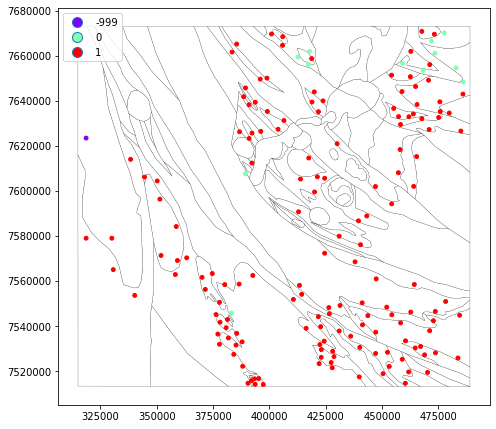

In [47]:
m2l_geometry.save_orientations_with_polarity(output_path+'orientations.csv',output_path,c_l,tmp_path+'basal_contacts.shp',tmp_path+'all_sorts.csv',)

m2l_utils.plot_points(output_path+'orientations_polarity.csv',geol_clip,'polarity','X','Y',True)


## 6c Calculate minimum fault offset from stratigraphy and stratigraphic fault offset

,index,group number,index in group,number in group,group,uctype,thickness median
code,,,,,,,
NYOCg,0,1,1,1,OChallaghans_Granite,erode,0.0
NYMCg,1,2,1,1,Mount_Crofton_Granite,erode,0.0
NYW,2,3,1,6,Lamil,erode,0.0
NYP,3,3,2,6,Lamil,erode,1436.0
NYY,4,3,3,6,Lamil,erode,2248.0
NYZ,5,3,4,6,Lamil,erode,2786.0
NYA,6,3,5,6,Lamil,erode,0.0
NYMM,7,3,6,6,Lamil,erode,0.0
NYI,8,4,1,3,Throssell,erode,0.0


minumim stratigraphic offsets saved as ../fabiele/output/fault_strat_offset3.csv


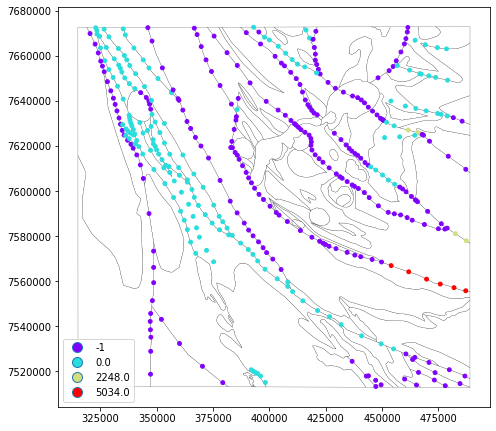

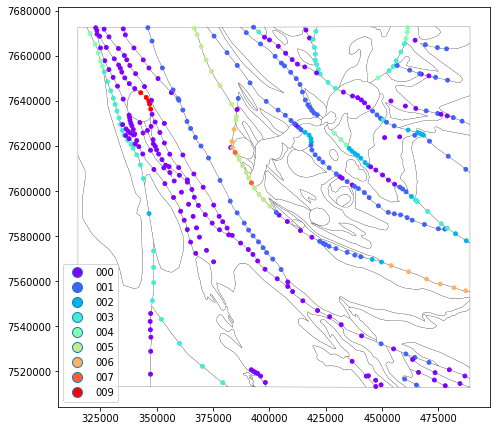

In [48]:
m2l_geometry.fault_strat_offset(output_path,c_l,dst_crs,output_path+'formation_summary_thicknesses.csv', tmp_path+'all_sorts.csv',tmp_path+'faults_clip.shp',tmp_path+'geol_clip.shp',output_path+'fault_dimensions.csv')


m2l_utils.plot_points(output_path+'fault_strat_offset3.csv',geol_clip,'min_offset','X','Y',True)
m2l_utils.plot_points(output_path+'fault_strat_offset3.csv',geol_clip,'strat_offset','X','Y',True)


## Analyse fault-fault topology

cycles []


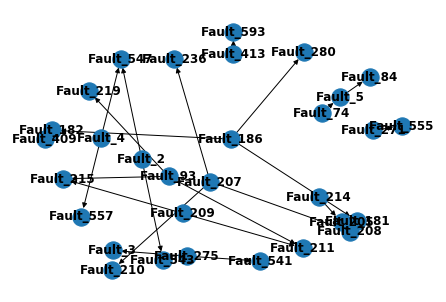

In [49]:
m2l_topology.parse_fault_relationships(graph_path,tmp_path,output_path)

# loop2gemodeller test 



In [50]:
save_faults=True
compute_etc=True
m2l_export.loop2geomodeller(test_data_path,tmp_path,output_path,'./dtm/dtm_rp.tif',bbox,save_faults,compute_etc,workflow)
t1 = time.time()

In [51]:
os.chdir(test_data_path)
%system geomodellerbatch.exe -batch m2l.taskfile
t2 = time.time()

In [52]:
#%system geomodellerbatch.exe -batch m2l_compute.taskfile
t3 = time.time()

In [53]:
print("m2l",(t1-t0)/60.0,"batch process",(t2-t1)/60.0,"batch calculate",(t3-t2)/60.0,"minutes")

m2l 5.806186906496683 batch process 1.3407150467236837 batch calculate 0.00021609862645467122 minutes


In [54]:
# use raster to define cover base
# use raster to define Z everywhere or use raster to define new dtm for everythng not cover (easier)